In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [474]:
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
# Load the dataset
types = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'InvoiceDate': str, 'UnitPrice': float, 'CustomerID': float, 'Country': str}
data = pd.read_csv('Online_Retail.csv', dtype=types, usecols=columns)

## Data preprocessing

In [475]:
prep_data = data[~data['InvoiceNo'].str.startswith('C')] # remove cancelled orders

In [476]:
prep_data.dropna(inplace=True) # remove rows with missing values

prep_data.drop_duplicates(inplace=True) # remove duplicate rows

In [477]:
prep_data['TotalPrice'] = prep_data['Quantity'] * prep_data['UnitPrice'] # calculate total price
prep_data['InvoiceDate'] = pd.to_datetime(prep_data['InvoiceDate']) # convert InvoiceDate to datetime




In [478]:
#remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
prep_data = remove_outliers(prep_data, 'TotalPrice') # remove outliers in TotalPrice
prep_data = remove_outliers(prep_data, 'Quantity') # remove outliers in Quantity
prep_data = remove_outliers(prep_data, 'UnitPrice') # remove outliers in UnitPrice


#### RFM prepration

In [479]:
RFM = prep_data.groupby(
    ['CustomerID']
).agg(
    {
        'InvoiceDate': lambda x: (prep_data['InvoiceDate'].max() - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'
    }
)
RFM.columns = ['Recency', 'Frequency', 'Monetary']

In [480]:
for metric in ['Recency', 'Frequency', 'Monetary']:
    RFM = remove_outliers(RFM, metric)

In [481]:
# from sklearn.preprocessing import StandardScaler
# RFM['Avg_Order_Value'] = RFM['Monetary'] / RFM['Frequency']
# RFM['Recency_Freq_Ratio'] = RFM['Recency'] / RFM['Frequency']
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(RFM[['Recency', 'Frequency', 'Monetary', 'Avg_Order_Value', 'Recency_Freq_Ratio']])

#### Clustering

In [482]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

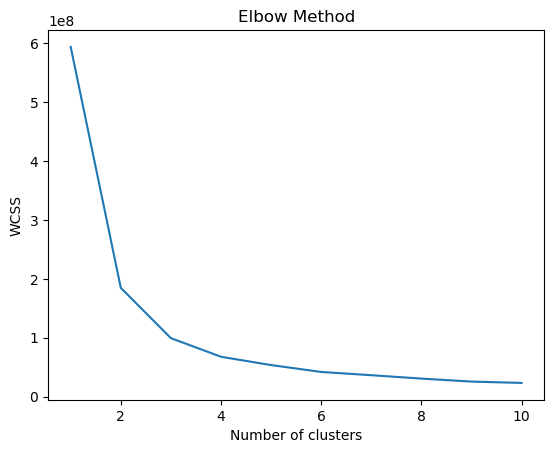

In [483]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(RFM)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [484]:
# Test different numbers of clusters and calculate silhouette scores
from sklearn.metrics import silhouette_score

for n in range(2, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(RFM)
    score = silhouette_score(RFM, labels)
    print(f"Number of Clusters: {n}, Silhouette Score: {score:.2f}")

Number of Clusters: 2, Silhouette Score: 0.63
Number of Clusters: 3, Silhouette Score: 0.53
Number of Clusters: 4, Silhouette Score: 0.47
Number of Clusters: 5, Silhouette Score: 0.40
Number of Clusters: 6, Silhouette Score: 0.41
Number of Clusters: 7, Silhouette Score: 0.42
Number of Clusters: 8, Silhouette Score: 0.39
Number of Clusters: 9, Silhouette Score: 0.40


In [485]:
k = 2  # Choose the number of clusters based on the elbow method and silhouette score

kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(RFM)

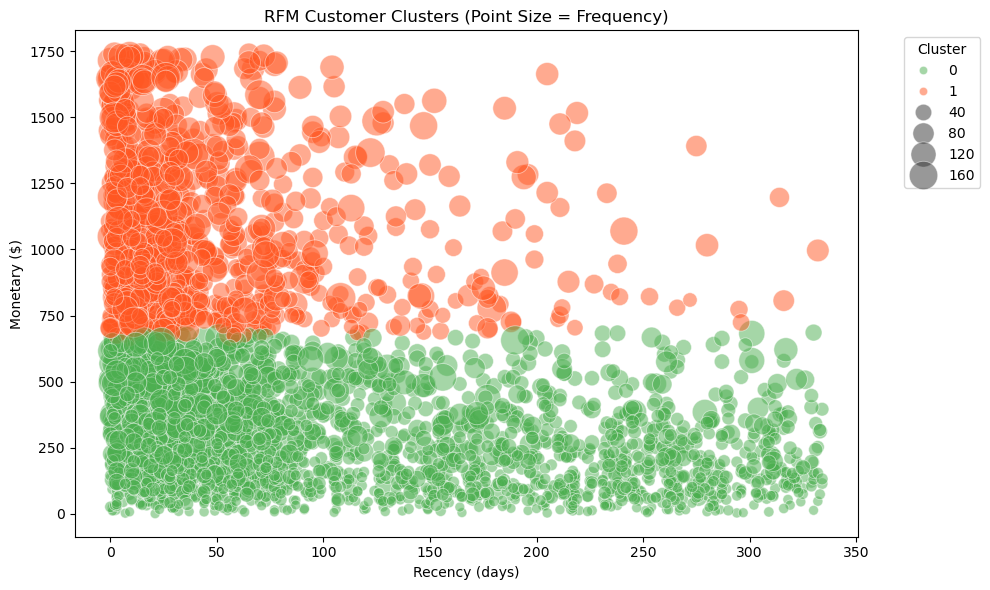

In [486]:


# Visualization 1: Scatter Plot (Recency vs. Monetary, Frequency as point size)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFM, x='Recency', y='Monetary', hue=labels, 
                size='Frequency', sizes=(50, 500), palette=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E'], alpha=0.5)
plt.title('RFM Customer Clusters (Point Size = Frequency)')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

this is not a good clustering its simplyifying the customers into two groups only 

### Try scoring with RFM

In [570]:
RFM['R_score'] = pd.qcut(RFM['Recency'], 5, labels=[5, 4, 3, 2, 1])
RFM['F_score'] = pd.qcut(RFM['Frequency'], 5, labels=[1, 2, 3, 4, 5])
RFM['M_score'] = pd.qcut(RFM['Monetary'], 5, labels=[1, 2, 3, 4, 5])
RFM['RFM_Segment'] = RFM['R_score'].astype(int) + RFM['F_score'].astype(int) + RFM['M_score'].astype(int)


In [574]:
def assign_segment(row):
    rfm_sum = row['RFM_Segment']
    r_score = row['R_score']
    
    if rfm_sum >= 12:
        return 'Champions'
    elif rfm_sum >= 11 and rfm_sum < 13:
        return 'Potential Champions'
    elif rfm_sum >= 8 and r_score >= 3:
        return 'New Customers'
    elif 8 <= rfm_sum <= 11 and r_score <= 3:
        return 'Loyal but Inactive'
    elif rfm_sum >= 6 and rfm_sum < 8 and row['F_score'] >= 3:
        return 'Mid-Tier'
    elif rfm_sum >= 5 and rfm_sum < 7 and 3 <= r_score <= 4:
        return 'Lost'
    elif rfm_sum >= 4 and rfm_sum < 5 and r_score < 3:
        return 'At Risk'
    else:
        return 'Churned'

# Apply segment assignment
RFM['Segment'] = RFM.apply(assign_segment, axis=1)  # Use apply with axis=1 to pass rows

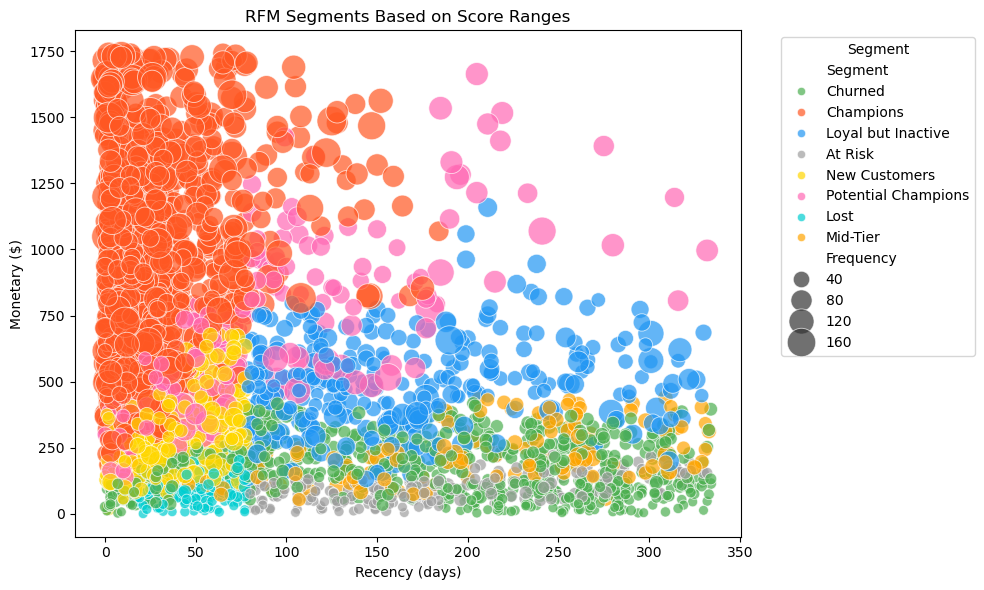

Segment Summary:
                         Recency  Frequency    Monetary  Count
Segment                                                      
At Risk              182.358491   7.325472   96.275519    212
Champions             27.793175  80.690796  939.874189    967
Churned              174.770195  11.259053  171.711379    718
Lost                  50.514423   5.937500   96.558894    208
Loyal but Inactive   167.353698  43.832797  494.549293    311
Mid-Tier             209.133333  29.237037  233.859037    135
New Customers         36.712281  25.070175  298.247319    570
Potential Champions   68.261324  53.397213  623.758293    287


In [576]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFM, x='Recency', y='Monetary', hue='Segment', 
                size='Frequency', sizes=(50, 500), palette=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E', '#FFD700', '#FF69B4', '#00CED1', '#FFA500'],alpha=0.7)
plt.title('RFM Segments Based on Score Ranges')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 5: Analyze segments
segment_summary = RFM.reset_index().groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})
print("Segment Summary:\n", segment_summary)

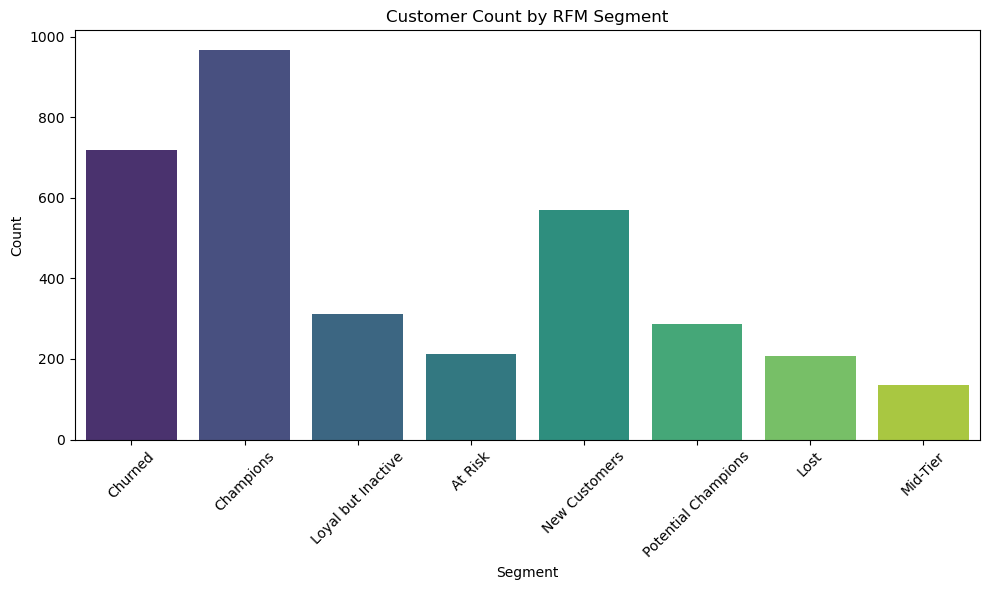

In [577]:
plt.figure(figsize=(10, 6))
sns.countplot(data=RFM, x='Segment', palette='viridis')
plt.title('Customer Count by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

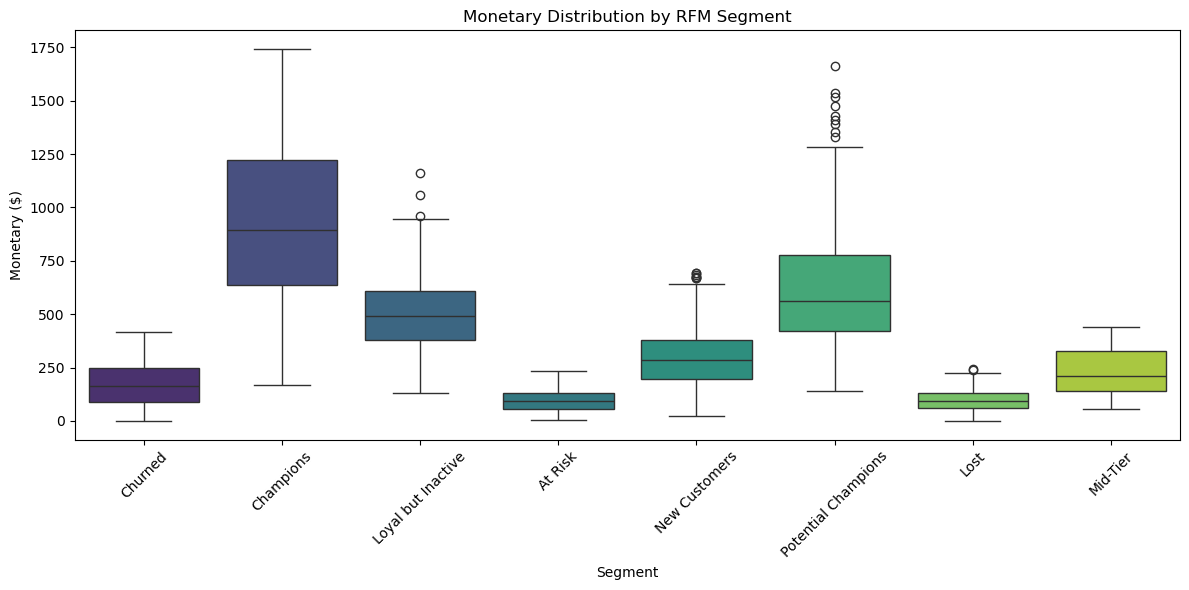

In [578]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=RFM, x='Segment', y='Monetary', palette='viridis')
plt.title('Monetary Distribution by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Monetary ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [593]:
RFM[RFM['Segment'] == 'Churned'].groupby('RFM_total').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

,Recency,Frequency,Monetary
RFM_total,,,
3,255.450495,4.717822,70.930594
5,201.798742,13.232704,170.993899
6,199.657534,16.328767,269.182123
7,59.943128,12.526066,201.289905
